# Recidivism Prediction Model Development

Our objective in the following notebook is to develop a robust machine learning (ML) model to predict recidivism. 

Notebook Outline:

1. **Data Loading and Preparation:** 
We begin by loading the dataset and conducting a series of preprocessing steps to prepare our data for modeling. This includes cleaning the data to address any missing or erroneous values, standardizing numerical features to bring them onto a common scale, and selecting the most relevant features.

2. **Training Baseline Model:**
This step is critical in setting a standard of performance with a simple yet effective logistic regression model. The baseline helps in quantifying improvements as we advance to more complex models and techniques.

3. **Testing Different Models, fine-tune evaluate using Nested Cross-Validation:**
To ensure the robustness and generalizability of our models, we employ Nested Cross-Validation. This process involves testing various types of models, namely, Support Vector Machines (SVMs), K-Nearest Neighbors, Random Forests, and Gradient Boosting Machines. Repeated Cross-Validation allows us to assess model performance consistently across different folds and repetitions, providing a thorough understanding of the model's reliability and performance. Each selected model will fine-tuned using GridSearchCV. This sophisticated technique enables us to search for the optimal hyperparameters while avoiding the risk of overfitting, as it provides an unbiased evaluation of the model's performance on unseen data.

4. **Test the top two winning models using Repeated Croos-Validation:**
The top two models based on nested cross-validation accuracy that emerge from the previous step will be evaluated using Repeated Croos-Validation. This method will allow us to assess the models' performances over multiple iterations, ensuring the reliability and stability of their predictive power.

**Model Evaluation Metrics**
Our evaluation framework will encompass a variety of metrics to comprehensively assess model performance. We will utilize the Area Under the Curve (AUC) and accuracy to measure overall performance, while also examining the confusion matrix to understand the models' prediction distribution across the different classes. Precision and recall will be critical in assessing the models' ability to identify true positives, which is especially important in the context of recidivism. The F1 score will be used as a harmonic mean of precision and recall, providing a single metric that balances both concerns.

Alongside traditional performance metrics, we will also compute *statistical parity and equalized odds ratios* to have peak of our models fairness, and we will consolidate all these metrics into a single comprehensive table for convenient analysis and comparison.

Let's dive in.

## 1. Data Loading and Preparation

In [1]:
# Load the data
import pandas as pd
from scipy.io import arff

file_path = 'data/compas.arff'
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)

df.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat_25-45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M
0,b'1',34.0,0.0,0.0,0.0,0.0,b'1',b'1',b'0',b'0',b'1',b'0',1.0,0.0
1,b'1',24.0,0.0,0.0,1.0,4.0,b'1',b'0',b'0',b'1',b'1',b'0',1.0,0.0
2,b'1',41.0,0.0,0.0,0.0,14.0,b'1',b'1',b'0',b'0',b'0',b'1',1.0,0.0
3,b'0',39.0,0.0,0.0,0.0,0.0,b'0',b'1',b'0',b'0',b'0',b'1',0.0,1.0
4,b'1',27.0,0.0,0.0,0.0,0.0,b'0',b'1',b'0',b'0',b'0',b'1',1.0,0.0


### 1.1 Feature enginnering

Since the dataset already contains binned age categories and other categorical variables are encoded, extensive feature engineering might not be necessary. We confirm that all features are in a suitable format for modeling.

### 1.2 Inspect missing values

In [4]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

No missing values.

### 1.3 Features' type conversion

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    5278 non-null   object 
 1   age                    5278 non-null   float64
 2   juv_fel_count          5278 non-null   float64
 3   juv_misd_count         5278 non-null   float64
 4   juv_other_count        5278 non-null   float64
 5   priors_count           5278 non-null   float64
 6   two_year_recid         5278 non-null   object 
 7   age_cat_25-45          5278 non-null   object 
 8   age_cat_Greaterthan45  5278 non-null   object 
 9   age_cat_Lessthan25     5278 non-null   object 
 10  race_African-American  5278 non-null   object 
 11  race_Caucasian         5278 non-null   object 
 12  c_charge_degree_F      5278 non-null   float64
 13  c_charge_degree_M      5278 non-null   float64
dtypes: float64(7), object(7)
memory usage: 577.4+ KB


The dataset contains several columns in byte string fromat (e.g., sex, tow_year_recid, age_cat_, etc). These need to be converted to a regular numerical format as ML algorthms expect input in numberical fromat.

In [7]:
def convert_byte_string_to_numeric(df):
    """
    Convert byte string columns in a DataFrame to numeric values if possible.

    This function iterates through each column of a given DataFrame. For columns with
    data type 'object', it decodes byte strings to UTF-8 formatted strings and
    attempts to convert these strings to numeric values. If conversion fails (due
    to non-numeric characters), the original string values are retained.

    Parameters:
    df: panda DataFrame to be processed.

    Returns:
    pd.DataFrame: A DataFrame with byte string columns converted to numeric values where possible.
    
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.decode('utf-8').str.strip()
            df[column] = pd.to_numeric(df[column], errors='ignore')
    return df

# Create a copy of the original DataFrame to avoid modifying it directly
df_converted = convert_byte_string_to_numeric(df.copy())

# Display the data types of the converted DataFrame
df_converted.dtypes

sex                        int64
age                      float64
juv_fel_count            float64
juv_misd_count           float64
juv_other_count          float64
priors_count             float64
two_year_recid             int64
age_cat_25-45              int64
age_cat_Greaterthan45      int64
age_cat_Lessthan25         int64
race_African-American      int64
race_Caucasian             int64
c_charge_degree_F        float64
c_charge_degree_M        float64
dtype: object

c_charge_degree_F and c_charge_degree_M are categorical features in float64 type which is uncommon. We will convert them to int64

In [9]:
# Convert 'c_charge_degree' from float to int
df_converted['c_charge_degree_F'] = df_converted['c_charge_degree_F'].astype('int64')
df_converted['c_charge_degree_M'] = df_converted['c_charge_degree_M'].astype('int64')

In [10]:
df_converted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    5278 non-null   int64  
 1   age                    5278 non-null   float64
 2   juv_fel_count          5278 non-null   float64
 3   juv_misd_count         5278 non-null   float64
 4   juv_other_count        5278 non-null   float64
 5   priors_count           5278 non-null   float64
 6   two_year_recid         5278 non-null   int64  
 7   age_cat_25-45          5278 non-null   int64  
 8   age_cat_Greaterthan45  5278 non-null   int64  
 9   age_cat_Lessthan25     5278 non-null   int64  
 10  race_African-American  5278 non-null   int64  
 11  race_Caucasian         5278 non-null   int64  
 12  c_charge_degree_F      5278 non-null   int64  
 13  c_charge_degree_M      5278 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 577.4 KB


### 1.4 Numircal features standardization

- Algorithms like Logistic Regression and SVM are sensitive to the scale of input features. Standardizing the features ensures that each feature contributes equally to the decision boundary.
- We will standardize the features that are not binary (age, juv_fel_count, juv_misd_count, juv_other_count, and priors_count) using StandardScaler (subtracts the mean and scales each feature to unit variance) from Scikit learn. 

In [11]:
from sklearn.preprocessing import StandardScaler

# Select columns to be standardized (non-binary features)
columns_to_standardize = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# Standardizing these columns
scaler = StandardScaler()
df_converted[columns_to_standardize] = scaler.fit_transform(df_converted[columns_to_standardize])

In [12]:
df_converted.head()

,sex,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat_25-45,age_cat_Greaterthan45,age_cat_Lessthan25,race_African-American,race_Caucasian,c_charge_degree_F,c_charge_degree_M
0,1,-0.038308,-0.14965,-0.190564,-0.247266,-0.709995,1,1,0,0,1,0,1,0
1,1,-0.890714,-0.14965,-0.190564,1.827564,0.110444,1,0,0,1,1,0,1,0
2,1,0.558376,-0.14965,-0.190564,-0.247266,2.161540,1,1,0,0,0,1,1,0
3,0,0.387895,-0.14965,-0.190564,-0.247266,-0.709995,0,1,0,0,0,1,0,1
4,1,-0.634992,-0.14965,-0.190564,-0.247266,-0.709995,0,1,0,0,0,1,1,0


### 1.5 Target variable imbalance check

We need to make sure that the traget variable 'two_year_recid' is balanced. If it is not balanced we will fix it because imbalanced dataset can lead to model bias towards the majority class.

In [13]:
target_balance = df_converted['two_year_recid'].value_counts(normalize=True)

target_balance

0    0.529557
1    0.470443
Name: two_year_recid, dtype: float64

The target variable is relatively balanced, with about 53% of the cases being in one class and 47% in the other. This balance suggests that we do not need to apply specific techniques for handling label imbalance. However, we will be using evaluation metrics that consider both classes effectively, such as precision, recall, F1 score, and ROC-AUC.

### 1.6 Feature(s) selection

- Reducing the number of features is recommended to reduce model complexity and the risk of overfitting.
- Considering the context of the data and that it's already been preprocessed to some extent, at this stage it seems all features are relevant but we will double check nontheless.

We can start by looking at the correlations between all variables and the target variable 'two_year_recid'. This will give us an initial understanding of which features might be more relevant for predicting recidivism.

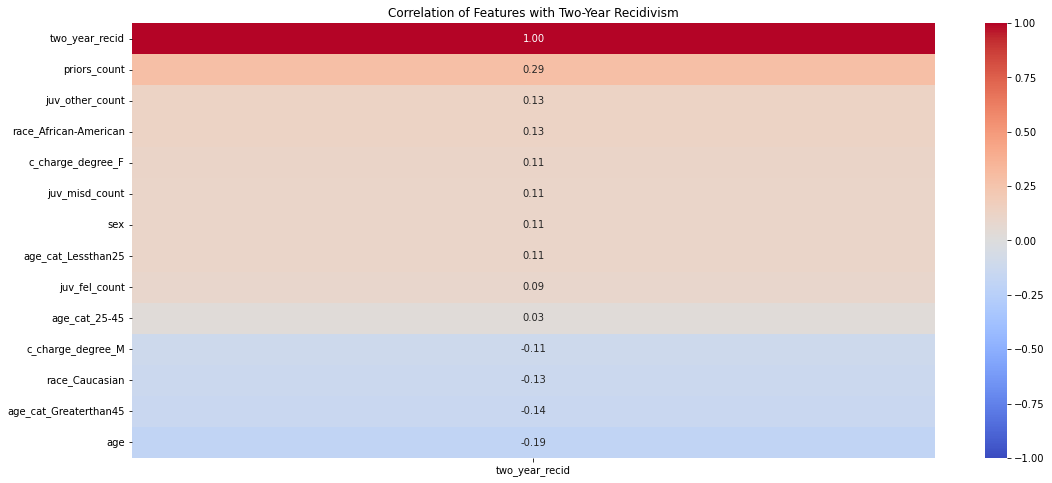

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix of the data
correlation_matrix = df_converted.corr()

plt.figure(figsize=(18, 8))

# Create a heatmap to visualize the correlation of each feature with 'two_year_recid'
# 'sns.heatmap' is used for creating the heatmap
# 'correlation_matrix[['two_year_recid']].sort_values(by='two_year_recid', ascending=False)' 
# sorts the correlations of features with 'two_year_recid' in descending order
# 'annot=True' annotates the heatmap with the correlation values
# 'cmap='coolwarm'' sets the color palette of the heatmap
# 'vmin=-1, vmax=1' sets the range of values for the colormap
# 'fmt=".2f"' formats the annotation to two decimal places

sns.heatmap(correlation_matrix[['two_year_recid']].sort_values(by='two_year_recid', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

# Set the title of the plot
plt.title("Correlation of Features with Two-Year Recidivism")

# Display the plot
plt.show()


**Key observations:**

1. Features with a positive correlation increase as the likelihood of recidivism increases. 'priors_count' shows the strongest positive correlation, which is logical as a higher number of prior offenses might indicate a higher likelihood of reoffending.

2. Features with a negative correlation decrease as the likelihood of recidivism increases. 'age' and 'age_cat_Greaterthan45' show a significant negative correlation, suggesting that older individuals are less likely to reoffend.

3. Both race_African-American and race_Caucasian show notable correlations. **This could be an indicator to produce a bias, race plays a substantial role in predicting recidivism.**

4. Other features like sex, age_cat_25-45, and c_charge_degree_F show moderate relative correlations.

Next we will plot a full correlation matrix to inspect how features are interacting with each other.

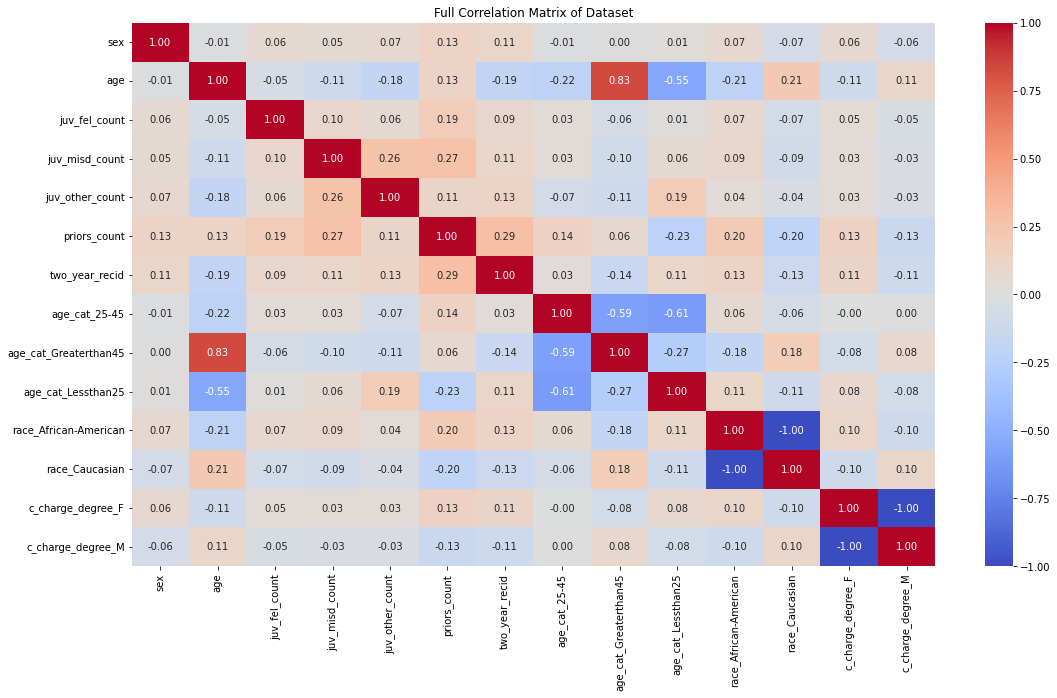

In [16]:
plt.figure(figsize=(18, 10))

# Creating a heatmap to visualize the correlation matrix with the same parameters to the previous step
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")

# Setting the title of the plot
plt.title("Full Correlation Matrix of Dataset")

# Displaying the plot
plt.show()


**Key observations:**

**Age (we will drop the numerical age feature here is why):**
- The age bins are derived directly from the numerical age variable, so they inherently contain similar information. This can lead to multicollinearity, where one variable can be linearly predicted from the others with a substantial degree of accuracy.
- The numerical age variable provides a continuous, linear interpretation of age. However, the age bins capture non-linear effects and can model different behaviors in different age groups. We assume this can be particularly useful because the relationship between age and recidivism is not linear but varies across different age ranges (check EDA notebook for more info).
- The correlation coefficients indicate that the age bins have different relationships with the target variable compared to the continuous age variable. This suggests that the age bins might capture aspects of the relationship between age and recidivism that the continuous variable does not.
- Including both age types increases model complexity, which might be justified if it improves predictive performance without overfitting. But after testing Logistic Regression with and without the combination of these features and compare their performance no significant difference were found (with age numerical accuracy= 0.65, without it accuracy= 0.66)

**Charge degree and race features:**
- Charge degree (c_charge_degree_F and c_charge_degree_M) and race features are mutually exclusive (if one is 1, the other is 0). Including both is redundant since knowing the value of one directly informs you about the other. We will drop one of these variables without losing information.

In [17]:
# dropping the 'age' feature
df_clean = df_converted.drop('age', axis=1)

# Creating the 'charge_degree' feature
df_clean['charge_degree'] = df_converted['c_charge_degree_F']

# Creating the 'race' feature (1 for African-American, 0 for Caucasian)
df_clean['race'] = df_converted['race_African-American']

# Dropping the original features
df_clean = df_clean.drop(['c_charge_degree_F', 'c_charge_degree_M', 'race_African-American', 'race_Caucasian'],
                         axis=1)


In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sex                    5278 non-null   int64  
 1   juv_fel_count          5278 non-null   float64
 2   juv_misd_count         5278 non-null   float64
 3   juv_other_count        5278 non-null   float64
 4   priors_count           5278 non-null   float64
 5   two_year_recid         5278 non-null   int64  
 6   age_cat_25-45          5278 non-null   int64  
 7   age_cat_Greaterthan45  5278 non-null   int64  
 8   age_cat_Lessthan25     5278 non-null   int64  
 9   charge_degree          5278 non-null   int64  
 10  race                   5278 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 453.7 KB


Sum up:
- The numeric age feature has been removed.
- A new feature **charge_degree** has been created, where 1 indicates a felony (originally c_charge_degree_F) and 0 indicates a misdemeanor.
- A new feature **race** has been created, where 1 represents African-American and 0 represents Caucasian. This is based on the original race_African-American feature.
- The original features c_charge_degree_F, c_charge_degree_M, race_African-American, and race_Caucasian have been removed to avoid redundancy.

The End of Data Loading and Preparation section

**Before moving on to modeling the next two code cells will be dedicated to declare three utility functions (skip this part):**
1. To keep track of the results from different models, we will create a structured approach for recording and comparing the performance metrics.
2. To measure and evaluate the fairness of a predictive model, particularly in sensitive applications. We will declare two functions, statistical_parity and equalized_odds, use Fairlearn's metrics to compute fairness measures. statistical_parity calculates metrics related to demographic parity, while equalized_odds calculates metrics related to error rates. 

In [77]:
# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=[
    'model_name', 
    'accuracy_nestedCV',
    'AUC', 
    'f1', 
    'precision', 
    'recall', 
    'statistical_parity_sex', 
    'equalized_odds_sex',
    'statistical_parity_race',
    'equalized_odds_race',
    'hyperparameters',
    'optimized_accuracy'
])

# Function to update the DataFrame with new results
def update_results(model_name, accuracy_nestedCV, AUC, f1, precision, recall, statistical_parity_sex, equalized_odds_sex, statistical_parity_race, equalized_odds_race, hyperparameters, optimized_accuracy):
    new_entry = {
        'model_name': model_name, 
        'accuracy_nestedCV': accuracy_nestedCV, 
        'AUC': AUC, 
        'f1': f1, 
        'precision': precision, 
        'recall': recall, 
        'statistical_parity_sex': statistical_parity_sex, 
        'equalized_odds_sex': equalized_odds_sex,
        'statistical_parity_race': statistical_parity_race, 
        'equalized_odds_race': equalized_odds_race, 
        'hyperparameters': hyperparameters,
        'optimized_accuracy': optimized_accuracy
    }
    return results_df.append(new_entry, ignore_index=True)

# Example usage after evaluating a model
# results_df = update_results(
#     model_name='Logistic Regression',
#     accuracy_nestedCV=0.85,  
#     AUC=0.90,  
#     f1=0.87, 
#     precision=0.88,  
#     recall=0.86, 
#     statistical_parity_sex =0.89, 
#     equalized_odds_sex =0.99,
#     statistical_parity_race = 0.23, 
#     equalized_odds_race =0.33, 
#     hyperparameters= f'C={}, max_iter={}',
#     optimised_accuracy=0.99
# )


In [22]:
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio

def statistical_parity(y_test, y_pred, feature):
    """
    Calculate statistical parity metrics.

    This function computes the statistical parity difference and ratio,
    which are measures of fairness in terms of demographic parity.

    Parameters:
    y_test (pd DataFrame): True labels for the test data.
    y_pred (pd Serie): Predicted labels for the test data.
    feature (pd Serie): Sensitive feature based on which fairness is evaluated.

    Returns:
    dict: A dictionary containing the Statistical Parity Difference and Ratio.
    """

    stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=feature)
    stat_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=feature)
    
    return {
        "Statistical Parity Difference": round(stat_parity_diff, 3),
        "Statistical Parity ratio": round(stat_parity_ratio, 3)
    }

def equalized_odds(y_test, y_pred, feature):
    """
    Calculate equalized odds metrics.

    This function computes the equalized odds difference and ratio,
    which are measures of fairness in terms of error rates.

    Parameters:
    y_test (pd DataFrame): True labels for the test data.
    y_pred (pd Serie): Predicted labels for the test data.
    feature (pd Serie): Sensitive feature based on which fairness is evaluated.

    Returns:
    dict: A dictionary containing the Equalized Odds Difference and Ratio.
    """
    
    equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=feature)
    equal_odds_ratio = equalized_odds_ratio(y_test, y_pred, sensitive_features=feature)
    
    return {
        "Equalized Odds Difference": round(equal_odds_diff, 3),
        "Equalized Odds Ratio": round(equal_odds_ratio, 3)
    }


## 2. Training Baseline Model

We selected Logistic Regression as the baseline model for its straightforward implementation and interpretable model. As a simple model, it provides a benchmark for performance.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score

# Data Preparation
X = df_clean.drop(['two_year_recid'], axis=1)
y = df_clean['two_year_recid']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)


LogisticRegression()

In [34]:
# Model Evaluation
y_pred_base_log_reg = log_reg.predict(X_test)
precision_score_base_log_reg = precision_score(y_test, y_pred_base_log_reg)
recall_score_base_log_reg = recall_score(y_test, y_pred_base_log_reg)
conf_matrix_base_log_reg = confusion_matrix(y_test, y_pred_base_log_reg)
auc_base_log_reg = roc_auc_score(y_test, y_pred_base_log_reg)

In [35]:
print(report_base_log_reg)

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       849
           1       0.66      0.55      0.60       735

    accuracy                           0.66      1584
   macro avg       0.66      0.65      0.65      1584
weighted avg       0.66      0.66      0.65      1584



In [38]:
print(auc_base_log_reg)

0.6514290521862456


In [42]:
race_equalized_odds_base_log_reg = equalized_odds(y_test, y_pred_base_log_reg, X_test['race'])

In [43]:
print(race_equalized_odds_base_log_reg)

{'Equalized Odds Difference': 0.274, 'Equalized Odds Ratio': 0.496}


In [44]:
race_statistical_parity_base_log_reg = statistical_parity(y_test, y_pred_base_log_reg, X_test['race'])

In [45]:
print(race_statistical_parity_base_log_reg)

{'Statistical Parity Difference': 0.244, 'Statistical Parity ratio': 0.499}


### 2.1 Evaluate the model using Nested cross-validation

In [53]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

# Define the parameter grid for logistic regression
param_grid = {
    'C': np.logspace(-4, 4, 40), # Regularization strength
    'penalty': ['l1', 'l2']      # Regularization type
}

# Define the inner and outer cross-validation settings
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the base model
log_reg_cv = LogisticRegression(solver='liblinear')  # Using liblinear solver for l1 penalty

# Set up the GridSearchCV object for inner CV
grid_search = GridSearchCV(estimator=log_reg_cv, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Run nested cross-validation and compute the average score
nested_score = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)

In [54]:
log_reg_nestedCV_accuracy = nested_score.mean()
print("Average accuracy from nested CV:", log_reg_nestedCV_accuracy)

Average accuracy from nested CV: 0.6683792277706269


### 2.2 Fine-tuning the model using GirdSearchCV

In [56]:
# Initialize the logistic regression model
log_reg = LogisticRegression(solver='liblinear', random_state=42)  # Using 'liblinear' for l1 and l2 penalties

# Set up the GridSearchCV object
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [57]:
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

Best parameters found:  {'C': 0.011253355826007646, 'penalty': 'l2'}
Best accuracy found:  0.678399360448273


In [59]:
# Retraining the model with the best parameters
best_C = best_params['C']
best_penalty = best_params['penalty']

# Creating a new logistic regression model with the best parameters
optimized_logreg = LogisticRegression(solver='liblinear', C=best_C, penalty=best_penalty, random_state=42)
optimized_logreg.fit(X_train, y_train)

LogisticRegression(C=0.011253355826007646, random_state=42, solver='liblinear')

In [68]:
# Optimized Logistic Regression Model Evaluation 
y_pred_optimized_logreg = optimized_logreg.predict(X_test)
accuracy_score_optimized_logreg = accuracy_score(y_test, y_pred_optimized_logreg)
precision_score_optimized_logreg = precision_score(y_test, y_pred_optimized_logreg)
recall_score_optimized_logreg = recall_score(y_test, y_pred_optimized_logreg)
f1_score_optimized_logreg = f1_score(y_test, y_pred_optimized_logreg)
conf_matrix_optimized_logreg = confusion_matrix(y_test, y_pred_optimized_logreg)
auc_base_optimized_logreg = roc_auc_score(y_test, y_pred_optimized_logreg)

In [62]:
print(auc_base_optimized_logreg)

0.6470445421985048


In [63]:
race_statistical_parity_optimized_logreg = statistical_parity(y_test, y_pred_optimized_logreg, X_test['race'])
race_equalized_odds_optimized_logreg = equalized_odds(y_test, y_pred_optimized_logreg, X_test['race'])
sex_statistical_parity_optimized_logreg = statistical_parity(y_test, y_pred_optimized_logreg, X_test['sex'])
sex_equalized_odds_optimized_logreg = equalized_odds(y_test, y_pred_optimized_logreg, X_test['sex'])

In [79]:
results_df = update_results(
     model_name='Logistic Regression',
     accuracy_nestedCV=log_reg_nestedCV_accuracy,  
     AUC=auc_base_optimized_logreg,  
     f1=f1_score_optimized_logreg, 
     precision=precision_score_optimized_logreg,  
     recall=recall_score_optimized_logreg, 
     statistical_parity_sex =sex_statistical_parity_optimized_logreg, 
     equalized_odds_sex =sex_equalized_odds_optimized_logreg,
     statistical_parity_race = race_statistical_parity_optimized_logreg, 
     equalized_odds_race =race_equalized_odds_optimized_logreg, 
     hyperparameters= best_params,
     optimized_accuracy=accuracy_score_optimized_logreg
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_64515/110754608.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [80]:
results_df

,model_name,accuracy_nestedCV,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race,hyperparameters,optimized_accuracy
0,Logistic Regression,0.668379,0.647045,0.570294,0.685115,0.488435,"{'Statistical Parity Difference': 0.231, 'Stat...","{'Equalized Odds Difference': 0.27, 'Equalized...","{'Statistical Parity Difference': 0.261, 'Stat...","{'Equalized Odds Difference': 0.33, 'Equalized...","{'C': 0.011253355826007646, 'penalty': 'l2'}",0.65846


## 3. Testing Different Models

### 3.1 Support Vector Classifier

#### 3.1.1 SVC Nested cross-validation

In [92]:
from sklearn.svm import SVC

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100, 100],  # Example values for C
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],  # Example values for gamma
    'kernel': ['linear', 'rbf']  # Kernel types
}

# Define the inner and outer cross-validation settings
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVC model
svm_NestedCV = SVC(random_state=42)

# Set up the GridSearchCV object for inner CV
grid_search = GridSearchCV(estimator=svm_NestedCV, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Run nested cross-validation and compute the average score
nested_score = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)

In [93]:
SVC_nestedCV_accuracy = nested_score.mean()
print("Average accuracy from nested CV:", SVC_nestedCV_accuracy)

Average accuracy from nested CV: 0.665672867824754


#### 3.1.2 Fine-tuning SVC GridSearchCV

In [94]:
# Initialize the SVM classifier
svm_classifier = SVC(random_state=42)

# Set up the GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [95]:
# Print the results
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

Best parameters found:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best accuracy found:  0.6756948340795992


In [96]:
# Evaluate the best model on the test set
optimized_svc = grid_search.best_estimator_
y_pred_svc = optimized_svc.predict(X_test)

print("Test set accuracy: ", accuracy_score(y_test, y_pred_svc))
print("Classification report:\n", classification_report(y_test, y_pred_svc))

Test set accuracy:  0.6584595959595959
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.70       849
           1       0.65      0.57      0.61       735

    accuracy                           0.66      1584
   macro avg       0.66      0.65      0.65      1584
weighted avg       0.66      0.66      0.66      1584



In [97]:
# Optimized Logistic Regression Model Evaluation 
accuracy_score_optimized_svc = accuracy_score(y_test, y_pred_svc)
precision_score_optimized_svc = precision_score(y_test, y_pred_svc)
recall_score_optimized_svc = recall_score(y_test, y_pred_svc)
f1_score_optimized_svc = f1_score(y_test, y_pred_svc)
conf_matrix_optimized_svc = confusion_matrix(y_test, y_pred_svc)
auc_base_optimized_svc = roc_auc_score(y_test, y_pred_svc)

In [98]:
race_statistical_parity_optimized_svc = statistical_parity(y_test, y_pred_svc, X_test['race'])
race_equalized_odds_optimized_svc = equalized_odds(y_test, y_pred_svc, X_test['race'])
sex_statistical_parity_optimized_svc = statistical_parity(y_test, y_pred_svc, X_test['sex'])
sex_equalized_odds_optimized_svc = equalized_odds(y_test, y_pred_svc, X_test['sex'])

In [99]:
results_df = update_results(
     model_name='Support Vector Classifier (SVC)',
     accuracy_nestedCV=SVC_nestedCV_accuracy,  
     AUC=auc_base_optimized_svc,  
     f1=f1_score_optimized_svc, 
     precision=precision_score_optimized_svc,  
     recall=recall_score_optimized_svc, 
     statistical_parity_sex =sex_statistical_parity_optimized_svc, 
     equalized_odds_sex =sex_equalized_odds_optimized_svc,
     statistical_parity_race = race_statistical_parity_optimized_svc, 
     equalized_odds_race =race_equalized_odds_optimized_svc, 
     hyperparameters= best_params,
     optimized_accuracy=accuracy_score_optimized_svc
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_64515/110754608.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [101]:
results_df

,model_name,accuracy_nestedCV,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race,hyperparameters,optimized_accuracy
0,Logistic Regression,0.668379,0.647045,0.570294,0.685115,0.488435,"{'Statistical Parity Difference': 0.231, 'Stat...","{'Equalized Odds Difference': 0.27, 'Equalized...","{'Statistical Parity Difference': 0.261, 'Stat...","{'Equalized Odds Difference': 0.33, 'Equalized...","{'C': 0.011253355826007646, 'penalty': 'l2'}",0.65846
1,Support Vector Classifier (SVC),0.665673,0.652525,0.607687,0.650621,0.570068,"{'Statistical Parity Difference': 0.315, 'Stat...","{'Equalized Odds Difference': 0.387, 'Equalize...","{'Statistical Parity Difference': 0.308, 'Stat...","{'Equalized Odds Difference': 0.323, 'Equalize...","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.65846


### 3.2 K-Nearest Neighbors

#### 3.2.1 KNN Nested cross-validation

In [103]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': range(1, 31)  # Example: testing 1 to 30 neighbors
}

# Define the inner and outer cross-validation settings
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the KNeighborsClassifier
KNN_NestedCV = KNeighborsClassifier()

# Set up the GridSearchCV object for inner CV
grid_search = GridSearchCV(estimator=KNN_NestedCV, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Run nested cross-validation and compute the average score
nested_score = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)


In [104]:
KNN_nestedCV_accuracy = nested_score.mean()
print("Average accuracy from nested CV:", KNN_nestedCV_accuracy)

Average accuracy from nested CV: 0.6640453847028323


#### 3.2.2 Fine-tuning KNN GridSearchCV

In [105]:

# Initialize the KNeighborsClassifier
KNN_cv = KNeighborsClassifier()

# Set up the GridSearchCV object
grid_search = GridSearchCV(KNN_cv, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [106]:
# Print the results
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

Best parameters found:  {'n_neighbors': 28}
Best accuracy found:  0.6737952481013308


In [107]:
# Evaluate the best model on the test set
optimized_knn = grid_search.best_estimator_
y_pred_knn = optimized_knn.predict(X_test)

print("Test set accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Classification report:\n", classification_report(y_test, y_pred_knn))

Test set accuracy:  0.6534090909090909
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.75      0.70       849
           1       0.65      0.54      0.59       735

    accuracy                           0.65      1584
   macro avg       0.65      0.65      0.65      1584
weighted avg       0.65      0.65      0.65      1584



In [109]:
# Optimized Logistic Regression Model Evaluation 
accuracy_score_optimized_KNN = accuracy_score(y_test, y_pred_knn)
precision_score_optimized_KNN = precision_score(y_test, y_pred_knn)
recall_score_optimized_KNN = recall_score(y_test, y_pred_knn)
f1_score_optimized_KNN = f1_score(y_test, y_pred_knn)
conf_matrix_optimized_KNN = confusion_matrix(y_test, y_pred_knn)
auc_base_optimized_KNN = roc_auc_score(y_test, y_pred_knn)

In [110]:
race_statistical_parity_optimized_KNN = statistical_parity(y_test, y_pred_knn, X_test['race'])
race_equalized_odds_optimized_KNN = equalized_odds(y_test, y_pred_knn, X_test['race'])
sex_statistical_parity_optimized_KNN = statistical_parity(y_test, y_pred_knn, X_test['sex'])
sex_equalized_odds_optimized_KNN = equalized_odds(y_test, y_pred_knn, X_test['sex'])

In [111]:
results_df = update_results(
     model_name='K-Nearest Neighbors (KNN)',
     accuracy_nestedCV=KNN_nestedCV_accuracy,  
     AUC=auc_base_optimized_KNN,  
     f1=f1_score_optimized_KNN, 
     precision=precision_score_optimized_KNN,  
     recall=recall_score_optimized_KNN, 
     statistical_parity_sex =sex_statistical_parity_optimized_KNN, 
     equalized_odds_sex =sex_equalized_odds_optimized_KNN,
     statistical_parity_race = race_statistical_parity_optimized_KNN, 
     equalized_odds_race =race_equalized_odds_optimized_KNN, 
     hyperparameters= best_params,
     optimized_accuracy=accuracy_score_optimized_KNN
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_64515/110754608.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [112]:
results_df

,model_name,accuracy_nestedCV,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race,hyperparameters,optimized_accuracy
0,Logistic Regression,0.668379,0.647045,0.570294,0.685115,0.488435,"{'Statistical Parity Difference': 0.231, 'Stat...","{'Equalized Odds Difference': 0.27, 'Equalized...","{'Statistical Parity Difference': 0.261, 'Stat...","{'Equalized Odds Difference': 0.33, 'Equalized...","{'C': 0.011253355826007646, 'penalty': 'l2'}",0.65846
1,Support Vector Classifier (SVC),0.665673,0.652525,0.607687,0.650621,0.570068,"{'Statistical Parity Difference': 0.315, 'Stat...","{'Equalized Odds Difference': 0.387, 'Equalize...","{'Statistical Parity Difference': 0.308, 'Stat...","{'Equalized Odds Difference': 0.323, 'Equalize...","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.65846
2,K-Nearest Neighbors (KNN),0.664045,0.646078,0.593032,0.651466,0.544218,"{'Statistical Parity Difference': 0.225, 'Stat...","{'Equalized Odds Difference': 0.253, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.303, 'Equalize...",{'n_neighbors': 28},0.653409


### 3.3 Random Forests

#### 3.3.1 RandomForests Nested cross-validation

In [114]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Define the inner and outer cross-validation settings
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Random Forest classifier
rf_NestedCV = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV object for inner CV
grid_search = GridSearchCV(estimator=rf_NestedCV, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Run nested cross-validation and compute the average score
nested_score = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)


In [115]:
rf_nestedCV_accuracy = nested_score.mean()
print("Average accuracy from nested CV:", rf_nestedCV_accuracy)

Average accuracy from nested CV: 0.6637740152773652


#### 3.3.2 Fine-tuning RandomForests GridSearchCV

In [116]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Set up the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [117]:
# Print the results
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best accuracy found:  0.681645525521561


In [119]:
# Evaluate the best model on the test set
optimized_rf = grid_search.best_estimator_
y_pred_rf = optimized_rf.predict(X_test)

print("Test set accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Classification report:\n", classification_report(y_test, y_pred_rf))

Test set accuracy:  0.6597222222222222
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70       849
           1       0.66      0.56      0.60       735

    accuracy                           0.66      1584
   macro avg       0.66      0.65      0.65      1584
weighted avg       0.66      0.66      0.66      1584



In [120]:
# Optimized Random Forests Model Evaluation 
accuracy_score_optimized_rf = accuracy_score(y_test, y_pred_rf)
precision_score_optimized_rf = precision_score(y_test, y_pred_rf)
recall_score_optimized_rf = recall_score(y_test, y_pred_rf)
f1_score_optimized_rf = f1_score(y_test, y_pred_rf)
conf_matrix_optimized_rf = confusion_matrix(y_test, y_pred_rf)
auc_base_optimized_rf = roc_auc_score(y_test, y_pred_rf)

In [121]:
race_statistical_parity_optimized_rf = statistical_parity(y_test, y_pred_rf, X_test['race'])
race_equalized_odds_optimized_rf = equalized_odds(y_test, y_pred_rf, X_test['race'])
sex_statistical_parity_optimized_rf = statistical_parity(y_test, y_pred_rf, X_test['sex'])
sex_equalized_odds_optimized_rf = equalized_odds(y_test, y_pred_rf, X_test['sex'])

In [122]:
results_df = update_results(
     model_name='Random Forest Classifier',
     accuracy_nestedCV=rf_nestedCV_accuracy,  
     AUC=auc_base_optimized_rf,  
     f1=f1_score_optimized_rf, 
     precision=precision_score_optimized_rf,  
     recall=recall_score_optimized_rf, 
     statistical_parity_sex =sex_statistical_parity_optimized_rf, 
     equalized_odds_sex =sex_equalized_odds_optimized_rf,
     statistical_parity_race = race_statistical_parity_optimized_rf, 
     equalized_odds_race =race_equalized_odds_optimized_rf, 
     hyperparameters= best_params,
     optimized_accuracy=accuracy_score_optimized_rf
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_64515/110754608.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [124]:
results_df

,model_name,accuracy_nestedCV,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race,hyperparameters,optimized_accuracy
0,Logistic Regression,0.668379,0.647045,0.570294,0.685115,0.488435,"{'Statistical Parity Difference': 0.231, 'Stat...","{'Equalized Odds Difference': 0.27, 'Equalized...","{'Statistical Parity Difference': 0.261, 'Stat...","{'Equalized Odds Difference': 0.33, 'Equalized...","{'C': 0.011253355826007646, 'penalty': 'l2'}",0.65846
1,Support Vector Classifier (SVC),0.665673,0.652525,0.607687,0.650621,0.570068,"{'Statistical Parity Difference': 0.315, 'Stat...","{'Equalized Odds Difference': 0.387, 'Equalize...","{'Statistical Parity Difference': 0.308, 'Stat...","{'Equalized Odds Difference': 0.323, 'Equalize...","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.65846
2,K-Nearest Neighbors (KNN),0.664045,0.646078,0.593032,0.651466,0.544218,"{'Statistical Parity Difference': 0.225, 'Stat...","{'Equalized Odds Difference': 0.253, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.303, 'Equalize...",{'n_neighbors': 28},0.653409
3,Random Forest Classifier,0.663774,0.65279,0.6028,0.657556,0.556463,"{'Statistical Parity Difference': 0.162, 'Stat...","{'Equalized Odds Difference': 0.206, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.29, 'Equalized...","{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.659722


### 3.4 Gradient Boosting Machines

#### 3.4.1 Gradient Boosting Machines Nested cross-validation

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Learning rate
    'max_depth': [3, 4, 5, 6]  # Maximum depth of the individual regression estimators
}

# Define the inner and outer cross-validation settings
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Random Forest classifier
GB_NestedCV = GradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV object for inner CV
grid_search = GridSearchCV(estimator=GB_NestedCV, param_grid=param_grid, cv=inner_cv, scoring='accuracy')

# Run nested cross-validation and compute the average score
nested_score = cross_val_score(grid_search, X_train, y_train, cv=outer_cv)

In [126]:
GB_nestedCV_accuracy = nested_score.mean()
print("Average accuracy from nested CV:", GB_nestedCV_accuracy)

Average accuracy from nested CV: 0.6792035674077985


#### 3.4.2 Fine-tuning Gradient Boosting Machines GridSearchCV

In [127]:
# Initialize the Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Set up the GridSearchCV object
grid_search = GridSearchCV(gb_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [128]:
# Print the results
print("Best parameters found: ", best_params)
print("Best accuracy found: ", best_score)


Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best accuracy found:  0.684084549911805


In [129]:
# Evaluate the best model on the test set
optimized_gb = grid_search.best_estimator_
y_pred_gb = optimized_gb.predict(X_test)

print("Test set accuracy: ", accuracy_score(y_test, y_pred_gb))
print("Classification report:\n", classification_report(y_test, y_pred_gb))

Test set accuracy:  0.6603535353535354
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70       849
           1       0.65      0.58      0.61       735

    accuracy                           0.66      1584
   macro avg       0.66      0.65      0.66      1584
weighted avg       0.66      0.66      0.66      1584



In [130]:
# Optimized Random Forests Model Evaluation 
accuracy_score_optimized_gb = accuracy_score(y_test, y_pred_gb)
precision_score_optimized_gb = precision_score(y_test, y_pred_gb)
recall_score_optimized_gb = recall_score(y_test, y_pred_gb)
f1_score_optimized_gb = f1_score(y_test, y_pred_gb)
conf_matrix_optimized_gb = confusion_matrix(y_test, y_pred_gb)
auc_base_optimized_gb = roc_auc_score(y_test, y_pred_gb)

In [131]:
race_statistical_parity_optimized_gb = statistical_parity(y_test, y_pred_gb, X_test['race'])
race_equalized_odds_optimized_gb = equalized_odds(y_test, y_pred_gb, X_test['race'])
sex_statistical_parity_optimized_gb = statistical_parity(y_test, y_pred_gb, X_test['sex'])
sex_equalized_odds_optimized_gb = equalized_odds(y_test, y_pred_gb, X_test['sex'])

In [132]:
results_df = update_results(
     model_name='Gradient Boosting Classifier',
     accuracy_nestedCV=GB_nestedCV_accuracy,  
     AUC=auc_base_optimized_gb,  
     f1=f1_score_optimized_gb, 
     precision=precision_score_optimized_gb,  
     recall=recall_score_optimized_gb, 
     statistical_parity_sex =sex_statistical_parity_optimized_gb, 
     equalized_odds_sex =sex_equalized_odds_optimized_gb,
     statistical_parity_race = race_statistical_parity_optimized_gb, 
     equalized_odds_race =race_equalized_odds_optimized_gb, 
     hyperparameters= best_params,
     optimized_accuracy=accuracy_score_optimized_gb
)

/var/folders/h5/r3ldzs6x5bxb71r4t20ydphh0000gn/T/ipykernel_64515/110754608.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return results_df.append(new_entry, ignore_index=True)


In [133]:
results_df

,model_name,accuracy_nestedCV,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race,hyperparameters,optimized_accuracy
0,Logistic Regression,0.668379,0.647045,0.570294,0.685115,0.488435,"{'Statistical Parity Difference': 0.231, 'Stat...","{'Equalized Odds Difference': 0.27, 'Equalized...","{'Statistical Parity Difference': 0.261, 'Stat...","{'Equalized Odds Difference': 0.33, 'Equalized...","{'C': 0.011253355826007646, 'penalty': 'l2'}",0.65846
1,Support Vector Classifier (SVC),0.665673,0.652525,0.607687,0.650621,0.570068,"{'Statistical Parity Difference': 0.315, 'Stat...","{'Equalized Odds Difference': 0.387, 'Equalize...","{'Statistical Parity Difference': 0.308, 'Stat...","{'Equalized Odds Difference': 0.323, 'Equalize...","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.65846
2,K-Nearest Neighbors (KNN),0.664045,0.646078,0.593032,0.651466,0.544218,"{'Statistical Parity Difference': 0.225, 'Stat...","{'Equalized Odds Difference': 0.253, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.303, 'Equalize...",{'n_neighbors': 28},0.653409
3,Random Forest Classifier,0.663774,0.65279,0.6028,0.657556,0.556463,"{'Statistical Parity Difference': 0.162, 'Stat...","{'Equalized Odds Difference': 0.206, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.29, 'Equalized...","{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.659722
4,Gradient Boosting Classifier,0.679204,0.654931,0.61295,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statis...","{'Equalized Odds Difference': 0.244, 'Equalize...","{'Statistical Parity Difference': 0.23, 'Stati...","{'Equalized Odds Difference': 0.263, 'Equalize...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.660354


## 4. Test the Top Two Winning Models using Repeated Cross-Validation

In [134]:
results_df.sort_values(by='accuracy_nestedCV', ascending=False)

,model_name,accuracy_nestedCV,AUC,f1,precision,recall,statistical_parity_sex,equalized_odds_sex,statistical_parity_race,equalized_odds_race,hyperparameters,optimized_accuracy
4,Gradient Boosting Classifier,0.679204,0.654931,0.61295,0.650382,0.579592,"{'Statistical Parity Difference': 0.2, 'Statis...","{'Equalized Odds Difference': 0.244, 'Equalize...","{'Statistical Parity Difference': 0.23, 'Stati...","{'Equalized Odds Difference': 0.263, 'Equalize...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.660354
0,Logistic Regression,0.668379,0.647045,0.570294,0.685115,0.488435,"{'Statistical Parity Difference': 0.231, 'Stat...","{'Equalized Odds Difference': 0.27, 'Equalized...","{'Statistical Parity Difference': 0.261, 'Stat...","{'Equalized Odds Difference': 0.33, 'Equalized...","{'C': 0.011253355826007646, 'penalty': 'l2'}",0.65846
1,Support Vector Classifier (SVC),0.665673,0.652525,0.607687,0.650621,0.570068,"{'Statistical Parity Difference': 0.315, 'Stat...","{'Equalized Odds Difference': 0.387, 'Equalize...","{'Statistical Parity Difference': 0.308, 'Stat...","{'Equalized Odds Difference': 0.323, 'Equalize...","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.65846
2,K-Nearest Neighbors (KNN),0.664045,0.646078,0.593032,0.651466,0.544218,"{'Statistical Parity Difference': 0.225, 'Stat...","{'Equalized Odds Difference': 0.253, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.303, 'Equalize...",{'n_neighbors': 28},0.653409
3,Random Forest Classifier,0.663774,0.65279,0.6028,0.657556,0.556463,"{'Statistical Parity Difference': 0.162, 'Stat...","{'Equalized Odds Difference': 0.206, 'Equalize...","{'Statistical Parity Difference': 0.254, 'Stat...","{'Equalized Odds Difference': 0.29, 'Equalized...","{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.659722


In [138]:
gb_hyperparameters = results_df.iloc[4, 10]
log_reg_hyperparameters = results_df.iloc[0, 10]

In [141]:
gb_hyperparameters['learning_rate']

0.01

In [144]:
# Data Preparation
X = df_clean.drop(['two_year_recid'], axis=1)
y = df_clean['two_year_recid']

# Initialize a list to store accuracy scores
gbc_accuracy = []
log_reg_accuracy = []

# Repeat the train/test split 20 times with different random seeds
for i in range(100):
    random_state = i  # Use i as the random seed
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
    
    # Create and fit the Gradient Boosting Classifier and Logisitic Regression
    gbc = GradientBoostingClassifier(learning_rate=gb_hyperparameters['learning_rate'], 
                                     max_depth=gb_hyperparameters['max_depth'], 
                                     n_estimators=gb_hyperparameters['n_estimators'], 
                                     random_state=random_state)
    gbc.fit(X_train, y_train)

    log_reg = LogisticRegression(C=log_reg_hyperparameters['C'], 
                                 penalty=log_reg_hyperparameters['penalty'],
                                 solver='liblinear',
                                 random_state=random_state)
    log_reg.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_gbc = gbc.predict(X_test)
    y_pred_logreg = log_reg.predict(X_test)
    
    # Calculate accuracy score and append it to the list
    gbc_accuracy.append(accuracy_score(y_test, y_pred_gbc))
    log_reg_accuracy.append(accuracy_score(y_test, y_pred_logreg))


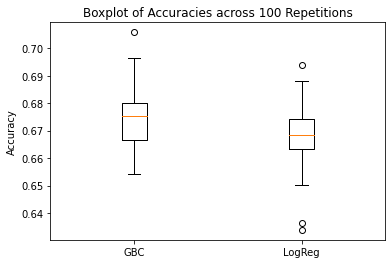

In [145]:
# Plot a boxplot of the accuracies
plt.boxplot([gbc_accuracy, log_reg_accuracy])
plt.title('Boxplot of Accuracies across 100 Repetitions')
plt.xticks([1,2],['GBC','LogReg'])
plt.ylabel('Accuracy')
plt.show()

In [149]:
print("Gradient Boosting Classifier average performance:", round(np.mean(gbc_accuracy), 3))
print("Logistic Regression average performance:", round(np.mean(log_reg_accuracy), 3))

Gradient Boosting Classifier average performance: 0.674
Logistic Regression average performance: 0.668


After an extensive evaluation process using Repeated Cross-Validation with various split random states, we have gathered substantial evidence to conclude that the Gradient Boosting Classifier consistently outperforms the Logistic Regression model in predicting recidivism. This conclusion is drawn from an average performance metric across multiple iterations and random splits, ensuring a robust comparison between the two models.

The superior performance of the Gradient Boosting Classifier could be attributed to its ability to model complex, non-linear relationships in the data. While the Logistic Regression model offers simplicity and interpretability, the Gradient Boosting Classifier provides a more nuanced understanding of the underlying patterns in the data, which is crucial for accurate predictions in the context of criminal justice.

Moving forward, our focus would be on fine-tuning the Gradient Boosting Classifier to further enhance its predictive performance while ensuring that it adheres to fairness principles and does not exacerbate existing biases. 

In [153]:
df_clean.to_csv('data/df_cleaned.csv', index=False)